# TADBSCAN Stop Detection

The second stop detection algorithm implemented in ```nomad``` is an adaptation of DBSCAN. Unlike in plain DBSCAN, we also incorporate the time dimension to determine if two pings are "neighbors". This implementation relies on 3 parameters

* `time_thresh` defines the maximum time difference (in minutes) between two consecutive pings for them to be considered neighbors within the same cluster.
* `dist_thresh` specifies the maximum spatial distance (in meters) between two pings for them to be considered neighbors.
* `min_pts` sets the minimum number of neighbors required for a ping to form a cluster.

Notice that this method also works with **geographic coordinates** (lon, lat), using Haversine distance. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Imports
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import box
from nomad.stop_detection.viz import plot_stops_barcode, plot_time_barcode, plot_stops, plot_pings
import nomad.stop_detection.dbscan as DBSCAN

# Load data
import nomad.data as data_folder
from pathlib import Path
data_dir = Path(data_folder.__file__).parent
city = gpd.read_parquet(data_dir / 'garden-city-buildings-mercator.parquet')
outer_box = box(*city.total_bounds)

filepath_root = 'gc_data_long/'
tc = {"user_id": "gc_identifier", "x": "dev_x", "y": "dev_y", "timestamp": "unix_ts"}

# Density based stop detection (Temporal DBSCAN)
users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters=('date','==', '2024-01-01'), traj_cols=tc)

stops_tadb = DBSCAN.ta_dbscan(traj,
                    time_thresh=60,
                    dist_thresh=10,
                    min_pts=3,
                    complete_output=True,
                    traj_cols=tc)    

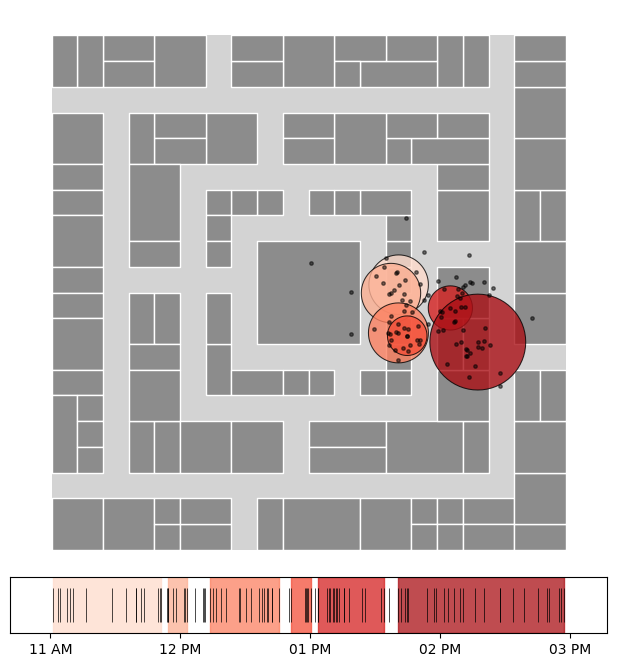

In [2]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

gpd.GeoDataFrame(geometry=[outer_box], crs='EPSG:3857').plot(ax=ax_map, color='#d3d3d3')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#8c8c8c')

plot_stops(stops_tadb, ax=ax_map, cmap='Reds')
plot_pings(traj, ax=ax_map, s=6, color='black', alpha=0.5, traj_cols=tc)
ax_map.set_axis_off()

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_tadb, ax=ax_barcode, cmap='Reds', set_xlim=False, timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()